# Importing the neccesary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.callbacks import ReduceLROnPlateau
from transformers import VivitImageProcessor, VivitForVideoClassification
import torch
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import copy
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")

# Model Loading

In [ ]:
num_classes = 99

In [ ]:
def build_model(fine_tune = False):
    model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400")
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    if not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)
    return model

model = build_model(False)
print(model)

In [ ]:
# Freezing the parameters not needed for training

cnt = 1
for params in model.parameters():

    if cnt <= 198:
        params.requires_grad = False
    else:
        params.requires_grad = True

    cnt += 1

In [ ]:
# Verifying which parameters are frozen

cnt = 1

for name, param in model.named_parameters():

    print(f'{cnt}: {name}: {"Trainable" if param.requires_grad else "Frozen"}')

    cnt+=1

# Dataset Loading

In [ ]:
# Loading the datasets stored as binary numpy files
train_videos = np.load("/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/train_data.npy")
valid_videos = np.load("/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/val_data.npy")
test_videos = np.load("/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/test_data.npy")

train_labels = np.load("/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/train_label.npy")
valid_labels = np.load("/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/val_label.npy")
test_labels = np.load("/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/test_label.npy")

In [ ]:
batch_size = 8

In [ ]:
# Defining a custom dataset class which inherits from torch.utils.data.Dataset
class CustomVideoDataset(Dataset):
    def __init__(self, video_files, labels, transform=None):
        self.video_files = video_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video = self.video_files[idx]
        label = self.labels[idx]

        if self.transform:
            video = self.transform(video)

        # Convert video and label to PyTorch tensors
        video = image_processor(list(video))
        video = torch.tensor(video['pixel_values'][0], dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return video, label

In [ ]:
# Create dataset and dataloader for training data
train_dataset = CustomVideoDataset(train_videos, train_labels)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Iterate over the dataloader
for batch_videos, batch_labels in trainloader:
    print(type(batch_videos))
    print(f"Batch videos shape: {batch_videos.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break  # Just to show the shape for one batch

In [ ]:
# Create dataset and dataloader for validation data
valid_dataset = CustomVideoDataset(valid_videos, valid_labels)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Iterate over the dataloader
for batch_videos, batch_labels in validloader:
    print(type(batch_videos))
    print(f"Batch videos shape: {batch_videos.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break  # Just to show the shape for one batch

In [ ]:
# Create dataset and dataloader for testing data
test_dataset = CustomVideoDataset(test_videos, test_labels)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Iterate over the dataloader
for batch_videos, batch_labels in testloader:
    print(type(batch_videos))
    print(f"Batch videos shape: {batch_videos.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break  # Just to show the shape for one batch

# Experiment 1

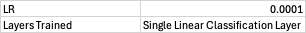

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_accuracy_epoch = []
train_loss_epoch = []

val_accuracy_epoch = []
val_loss_epoch = []

In [ ]:
#Initialize Variables for EarlyStopping
best_loss = float('inf')
best_model_weights = None
patience = 3

optimizer = optim.Adam(model.parameters(), lr=0.0001)

my_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience = patience)

criterion = nn.CrossEntropyLoss()

num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

train_accuracy_epoch = []
train_loss_epoch = []

val_accuracy_epoch = []
val_loss_epoch = []

for epoch in range(num_epochs):

    train_running_loss = 0.0
    train_running_correct = 0
    train_bs_accumuator = 0

    valid_running_loss = 0.0
    valid_running_correct = 0
    valid_bs_accumuator = 0

    start_time = time.time()

    model.train()
    running_loss = 0.0

    # Training Loop
    for videos, labels in tqdm(trainloader):

        videos, labels = videos.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(videos)

        logits = outputs.logits

        train_bs_accumuator += logits.shape[0]

        # Compute loss
        loss = criterion(logits, labels)

        # Calculate the accuracy.
        _, preds = torch.max(logits, 1)

        train_running_correct += (preds == labels).sum().item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * videos.size(0)

        i += 1

    # Validation Loop
    model.eval()

    with torch.no_grad():
        for videos, labels in validloader:

            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos)

            logits = outputs.logits

            valid_bs_accumuator += logits.shape[0]

            # Compute loss
            loss = criterion(logits, labels)

            _, preds = torch.max(logits, 1)

            valid_running_correct += (preds == labels).sum().item()

            valid_running_loss += loss.item() * videos.size(0)

    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = 100. * (train_running_correct / train_bs_accumuator)

    valid_loss = valid_running_loss / len(validloader.dataset)
    valid_acc = 100. * (valid_running_correct / valid_bs_accumuator)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    train_accuracy_epoch.append(epoch_acc)
    train_loss_epoch.append(epoch_loss)

    val_accuracy_epoch.append(valid_acc)
    val_loss_epoch.append(valid_loss)

    my_lr_scheduler.step(valid_loss)

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience = 3
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_weights)

In [ ]:
# Plotting the accuracy curve
plt.plot(train_accuracy_epoch)
plt.plot(val_accuracy_epoch)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plotting the loss curve
plt.plot(train_loss_epoch)
plt.plot(val_loss_epoch)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
torch.save(model, "/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/model_7.pth")

In [ ]:
# Running the model on the test dataset
model.eval()  # Set the model to evaluation mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

test_running_correct = 0
test_bs_accumuator = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        logits = outputs.logits
        test_bs_accumuator += logits.shape[0]

        _, preds = torch.max(logits, 1)
        test_running_correct += (preds == labels).sum().item()

test_accuracy = 100. * test_running_correct / test_bs_accumuator

print(f"Test Accuracy: {test_accuracy:.2f}%")

# Experiment 2

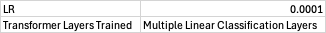

In [ ]:
# Defining a new classification layer

def build_model(fine_tune = False):
    model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400")
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    if not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Modify the model head for fine-tuning
    num_features = model.classifier.in_features

    # Additional linear layer and dropout layer
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 256),  # Additional linear layer with 256 output features
        nn.ReLU(inplace=True),         # Activation function (you can choose other activation functions too)
        nn.Dropout(0.5),               # Dropout layer with 50% probability
        nn.Linear(256, num_classes)    # Final prediction fc layer
    )

    return model

kka_model = build_model(False)
print(kka_model)

In [ ]:
# Verifying which parameters are frozen

cnt = 1

for name, param in kka_model.named_parameters():

    print(f'{cnt}: {name}: {"Trainable" if param.requires_grad else "Frozen"}')

    cnt+=1

In [ ]:
train_accuracy_epoch = []
train_loss_epoch = []

val_accuracy_epoch = []
val_loss_epoch = []

In [ ]:
#Initialize Variables for EarlyStopping
best_loss = float('inf')
best_model_weights = None
patience = 3

optimizer = optim.Adam(kka_model.parameters(), lr=0.0001)

my_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                             patience = patience)

criterion = nn.CrossEntropyLoss()

num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
kka_model.to(device)

train_accuracy_epoch = []
train_loss_epoch = []

val_accuracy_epoch = []
val_loss_epoch = []

for epoch in range(num_epochs):

    train_running_loss = 0.0
    train_running_correct = 0
    train_bs_accumuator = 0

    valid_running_loss = 0.0
    valid_running_correct = 0
    valid_bs_accumuator = 0

    start_time = time.time()

    kka_model.train()
    running_loss = 0.0

    # Training Loop
    for videos, labels in tqdm(trainloader):

        videos, labels = videos.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = kka_model(videos)

        logits = outputs.logits

        train_bs_accumuator += logits.shape[0]

        # Compute loss
        loss = criterion(logits, labels)

        # Calculate the accuracy.
        _, preds = torch.max(logits, 1)

        train_running_correct += (preds == labels).sum().item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * videos.size(0)

    # Validation Loop
    kka_model.eval()

    with torch.no_grad():
        for videos, labels in tqdm(validloader):

            videos, labels = videos.to(device), labels.to(device)

            outputs = kka_model(videos)

            logits = outputs.logits

            valid_bs_accumuator += logits.shape[0]

            # Compute loss
            loss = criterion(logits, labels)

            _, preds = torch.max(logits, 1)

            valid_running_correct += (preds == labels).sum().item()

            valid_running_loss += loss.item() * videos.size(0)

    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = 100. * (train_running_correct / train_bs_accumuator)

    valid_loss = valid_running_loss / len(validloader.dataset)
    valid_acc = 100. * (valid_running_correct / valid_bs_accumuator)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    train_accuracy_epoch.append(epoch_acc)
    train_loss_epoch.append(epoch_loss)

    val_accuracy_epoch.append(valid_acc)
    val_loss_epoch.append(valid_loss)

    my_lr_scheduler.step(valid_loss)

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model_weights = copy.deepcopy(kka_model.state_dict())
        patience = 3
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping triggered.")
            break

kka_model.load_state_dict(best_model_weights)

In [ ]:
# Plotting the accuracy curve
plt.plot(train_accuracy_epoch)
plt.plot(val_accuracy_epoch)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plotting the loss curve
plt.plot(train_loss_epoch)
plt.plot(val_loss_epoch)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
torch.save(kka_model, "/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/model_8_multi_layer_fc.pth")

In [ ]:
# Running the model on the test dataset
kka_model.eval()  # Set the model to evaluation mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

test_running_correct = 0
test_bs_accumuator = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = kka_model(images)

        logits = outputs.logits
        test_bs_accumuator += logits.shape[0]

        _, preds = torch.max(logits, 1)
        test_running_correct += (preds == labels).sum().item()

test_accuracy = 100. * test_running_correct / test_bs_accumuator

print(f"Test Accuracy: {test_accuracy:.2f}%")

# Experiment 3

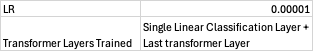

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_accuracy_epoch = []
train_loss_epoch = []

val_accuracy_epoch = []
val_loss_epoch = []

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

decayRate = 0.9
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

criterion = nn.CrossEntropyLoss()

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
model.to(device)

train_accuracy_epoch = []
train_loss_epoch = []

val_accuracy_epoch = []
val_loss_epoch = []

for epoch in range(num_epochs):

    train_running_loss = 0.0
    train_running_correct = 0
    train_bs_accumuator = 0

    valid_running_loss = 0.0
    valid_running_correct = 0
    valid_bs_accumuator = 0

    start_time = time.time()

    model.train()
    running_loss = 0.0

    # Training Loop
    for videos, labels in tqdm(trainloader):

        videos, labels = videos.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(videos)

        logits = outputs.logits

        train_bs_accumuator += logits.shape[0]

        # Compute loss
        loss = criterion(logits, labels)

        # Calculate the accuracy.
        _, preds = torch.max(logits, 1)

        train_running_correct += (preds == labels).sum().item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * videos.size(0)

    # Validation Loop
    with torch.no_grad():
        for videos, labels in tqdm(validloader):

            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos)

            logits = outputs.logits

            valid_bs_accumuator += logits.shape[0]

            # Compute loss
            loss = criterion(logits, labels)

            _, preds = torch.max(logits, 1)

            valid_running_correct += (preds == labels).sum().item()

            valid_running_loss += loss.item() * videos.size(0)

    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = 100. * (train_running_correct / train_bs_accumuator)

    valid_loss = valid_running_loss / len(validloader.dataset)
    valid_acc = 100. * (valid_running_correct / valid_bs_accumuator)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    train_accuracy_epoch.append(epoch_acc)
    train_loss_epoch.append(epoch_loss)

    val_accuracy_epoch.append(valid_acc)
    val_loss_epoch.append(valid_loss)

    my_lr_scheduler.step()

In [ ]:
# Plotting the accuracy curve
plt.plot(train_accuracy_epoch)
plt.plot(val_accuracy_epoch)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plotting the loss curve
plt.plot(train_loss_epoch)
plt.plot(val_loss_epoch)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
torch.save(model, "/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/model_5.pth")

In [ ]:
# Running the model on the test dataset
model.eval()  # Set the model to evaluation mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

test_running_correct = 0
test_bs_accumuator = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        logits = outputs.logits
        test_bs_accumuator += logits.shape[0]

        _, preds = torch.max(logits, 1)
        test_running_correct += (preds == labels).sum().item()

test_accuracy = 100. * test_running_correct / test_bs_accumuator

print(f"Test Accuracy: {test_accuracy:.2f}%")

# Experiment 4

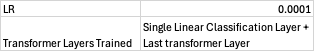

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_accuracy_epoch = []
train_loss_epoch = []

val_accuracy_epoch = []
val_loss_epoch = []

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

criterion = nn.CrossEntropyLoss()

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
model.to(device)

train_accuracy_epoch = []
train_loss_epoch = []

val_accuracy_epoch = []
val_loss_epoch = []

for epoch in range(num_epochs):

    train_running_loss = 0.0
    train_running_correct = 0
    train_bs_accumuator = 0

    valid_running_loss = 0.0
    valid_running_correct = 0
    valid_bs_accumuator = 0

    start_time = time.time()

    model.train()
    running_loss = 0.0

    # Training Loop
    for videos, labels in tqdm(trainloader):

        videos, labels = videos.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(videos)

        logits = outputs.logits

        train_bs_accumuator += logits.shape[0]

        # Compute loss
        loss = criterion(logits, labels)

        # Calculate the accuracy.
        _, preds = torch.max(logits, 1)

        train_running_correct += (preds == labels).sum().item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * videos.size(0)

        i += 1

    # Validation Loop
    with torch.no_grad():
        for videos, labels in validloader:

            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos)

            logits = outputs.logits

            valid_bs_accumuator += logits.shape[0]

            # Compute loss
            loss = criterion(logits, labels)

            _, preds = torch.max(logits, 1)

            valid_running_correct += (preds == labels).sum().item()

            valid_running_loss += loss.item() * videos.size(0)

    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = 100. * (train_running_correct / train_bs_accumuator)

    valid_loss = valid_running_loss / len(validloader.dataset)
    valid_acc = 100. * (valid_running_correct / valid_bs_accumuator)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    train_accuracy_epoch.append(epoch_acc)
    train_loss_epoch.append(epoch_loss)

    val_accuracy_epoch.append(valid_acc)
    val_loss_epoch.append(valid_loss)

    my_lr_scheduler.step()

In [ ]:
# Plotting the accuracy curve
plt.plot(train_accuracy_epoch)
plt.plot(val_accuracy_epoch)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plotting the loss curve
plt.plot(train_loss_epoch)
plt.plot(val_loss_epoch)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
torch.save(model, "/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/model_4.pth")

In [ ]:
# Running the model on the test dataset
model.eval()  # Set the model to evaluation mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

test_running_correct = 0
test_bs_accumuator = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        logits = outputs.logits
        test_bs_accumuator += logits.shape[0]

        _, preds = torch.max(logits, 1)
        test_running_correct += (preds == labels).sum().item()

test_accuracy = 100. * test_running_correct / test_bs_accumuator

print(f"Test Accuracy: {test_accuracy:.2f}%")

# Experiment 5

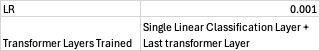

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_accuracy_epoch = []
train_loss_epoch = []

val_accuracy_epoch = []
val_loss_epoch = []

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
model.to(device)

train_accuracy_epoch = []
train_loss_epoch = []

val_accuracy_epoch = []
val_loss_epoch = []

for epoch in range(num_epochs):

    train_running_loss = 0.0
    train_running_correct = 0
    train_bs_accumuator = 0

    valid_running_loss = 0.0
    valid_running_correct = 0
    valid_bs_accumuator = 0

    start_time = time.time()

    model.train()
    running_loss = 0.0

    # Training Loop
    for videos, labels in tqdm(trainloader):

        videos, labels = videos.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(videos)

        logits = outputs.logits

        train_bs_accumuator += logits.shape[0]

        # Compute loss
        loss = criterion(logits, labels)

        # Calculate the accuracy.
        _, preds = torch.max(logits, 1)

        train_running_correct += (preds == labels).sum().item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * videos.size(0)

    # Validation Loop
    with torch.no_grad():
        for videos, labels in validloader:

            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos)

            logits = outputs.logits

            valid_bs_accumuator += logits.shape[0]

            # Compute loss
            loss = criterion(logits, labels)

            _, preds = torch.max(logits, 1)

            valid_running_correct += (preds == labels).sum().item()

            valid_running_loss += loss.item() * videos.size(0)

    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = 100. * (train_running_correct / train_bs_accumuator)

    valid_loss = valid_running_loss / len(validloader.dataset)
    valid_acc = 100. * (valid_running_correct / valid_bs_accumuator)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    train_accuracy_epoch.append(epoch_acc)
    train_loss_epoch.append(epoch_loss)

    val_accuracy_epoch.append(valid_acc)
    val_loss_epoch.append(valid_loss)

    my_lr_scheduler.step()

In [ ]:
# Plotting the accuracy curve
plt.plot(train_accuracy_epoch)
plt.plot(val_accuracy_epoch)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plotting the loss curve
plt.plot(train_loss_epoch)
plt.plot(val_loss_epoch)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
torch.save(model, "/content/drive/MyDrive/AI Masters final project/data_32_80_80_3_no_0/model_3.pth")

In [ ]:
# Running the model on the test dataset
model.eval()  # Set the model to evaluation mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

test_running_correct = 0
test_bs_accumuator = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        logits = outputs.logits
        test_bs_accumuator += logits.shape[0]

        _, preds = torch.max(logits, 1)
        test_running_correct += (preds == labels).sum().item()

test_accuracy = 100. * test_running_correct / test_bs_accumuator

print(f"Test Accuracy: {test_accuracy:.2f}%")